In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import os


In [3]:
# set working directory
os.chdir("/Users/giandomenico/Documents/SAPIENZA/AR/ABDAC/def_regionale")


In [4]:
#%% DR Functions

def detection_rate(probabilities, bins=np.arange(-0.05, 1.05, 0.05)):
    """ compute detection rate curves based on predicted probabilities and bins
    probabilities: array of probabilities between 0 and 1.
    bins: range of values to compute cumulative detection
    """
    # creo matrici di classi egualmente spaziate di 0.05
    #bins = np.arange(-0.05, 1.05, 0.05)
    # conteggio dei valori compresi in ciascun bin
    frequencies = np.histogram(probabilities, bins=bins, density=False)
    # trasformo le frequenze numeriche in percentuale %
    frequencies_percent = (frequencies[0]/len(probabilities)) * 100
    # calcola la cumulata delle frequenze e la inverto
    detection = 100 - (frequencies_percent.cumsum())
    dr = pd.DataFrame({'susceptibility':bins[1:], 'detection':detection})
    #zero_cento = pd.DataFrame(np.array([[0,100]]), columns=['bins', 'cumulata'])
    #output = pd.concat([zero_cento, output])
    
    return dr

def plot_dr(data, name, save=False):

    figure(num=None, figsize=(10,7), dpi=96, facecolor='w', edgecolor='black')
    plt.plot(data.susceptibility, data.detection, color='darkblue', linewidth=2, label=name)
    plt.xlabel('$bin$', fontsize=18)
    plt.ylabel('$cumulative$', fontsize=18)
    plt.gca().spines['top'].set_linewidth(2)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    plt.gca().spines['right'].set_linewidth(2)
    #plt.grid()
    plt.legend(frameon=False, fontsize=13)
    if save == True:
        plt.savefig('dr_{}.svg'.format(name), format='svg')
    plt.show()
    return

  
def dr_thresholds(dr, threshold_classes):
    """ compute thresholds given the detection_rate results
    """
    xp = dr.iloc[:, 1].tolist()
    fp = dr.iloc[:, 0].tolist()
    xp.reverse()
    fp.reverse()
    UNDEF = -99
    threshold = np.interp(threshold_classes, xp, fp, right=UNDEF, left=(UNDEF*-1))
    threshold = [round(i, 3) for i in threshold]
    threshold_df = pd.DataFrame({'DR':threshold_classes,'threshold':threshold})
    print('DR THRESHOLDS: ',threshold)

    return threshold_df


In [5]:
#%% Load Data and Model
from joblib import load

# load model
model_path = 'codici/model/gb_29042024.joblib'
model = load(model_path)

# Read x_test, y_test
X_test_path = 'dati/X_test.csv'
y_test_path = 'dati/y_test.csv'
X_test, y_test = pd.read_csv(X_test_path, index_col=0), pd.read_csv(y_test_path, index_col=0)
# merge df on index
xy_test = pd.merge(X_test, y_test, left_index=True, right_index=True)
# slice on pif
pif_test = xy_test.loc[xy_test['label'] == 1].drop(columns='label')

# predict proba
y_proba = pd.DataFrame(model.predict_proba(pif_test.values)[:,1].round(3))


In [6]:
#%% Detection Rate for Susc. Class Thresholds

classes = [20, 30, 50, 70]
classes_ = [100-i for i in classes]
print(classes_)

dr = detection_rate(y_proba, bins=np.arange(-0.02, 1.02, 0.02))
thr = dr_thresholds(dr, classes)

# plot DR curve
# plot_dr(data=dr, name='LIPs_test')

[80, 70, 50, 30]
DR THRESHOLDS:  [0.988, 0.982, 0.87, 0.56]


In [7]:
#%% ECDF
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n

    return x, y




x_pif, y_pif = ecdf(y_proba.iloc[:,0])

# Specify array of percentiles: percentiles
percentiles = np.array([75, 60, 45, 30])

# Compute percentiles: ptiles_vers
ptiles_pif = np.percentile(y_proba, percentiles).round(3)
# Print the result
print(ptiles_pif)

[0.996 0.947 0.818 0.561]


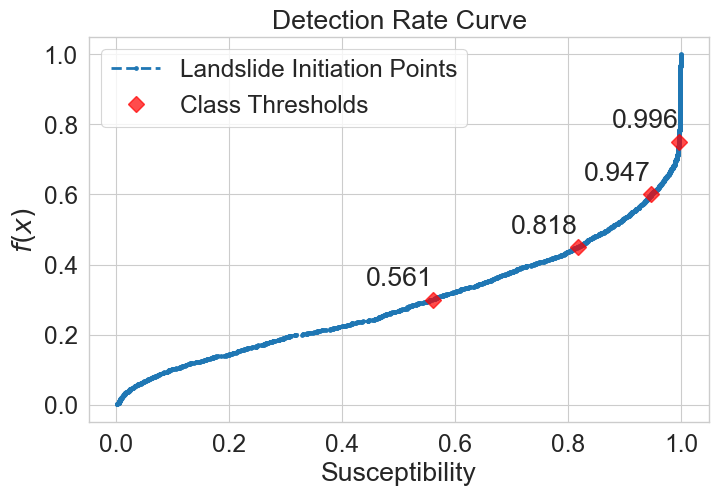

In [8]:
# Plot the ECDF
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)
plt.figure(figsize=(8,5))
_ = plt.plot(x_pif, y_pif, '.', linestyle='dashed', linewidth=2, label='Landslide Initiation Points')
_ = plt.xlabel('Susceptibility')
_ = plt.ylabel('$f(x)$')
_ = plt.title('Detection Rate Curve')
# Overlay percentiles as red diamonds.
_ = plt.plot(ptiles_pif, percentiles/100, marker='D', color='red', linestyle='none', markersize=8, alpha=0.7, label='Class Thresholds')
# Annotate each class threshold point
for x, y in zip(ptiles_pif, percentiles / 100):
    plt.annotate(f'{x:.3f}', # Formatting the value to 3 decimal places
                 (x, y),
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='right') # horizontal alignment can be left, right or center
# Show the plot
plt.legend(loc='upper left')
# plt.savefig('figure/dr_curve.svg', format='svg', bbox_inches='tight')
plt.show()